<a href="https://colab.research.google.com/github/TonyIssacJames/eva04_jan_2020_public/blob/master/File_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 4 - GAP, add layers and increase kernel size to match capacity

####  Targets:
  1. Add GAP
  2. run for 15 epochs(to save time) and see how things goes
  3. no data agumentation for now
  4. add layers to compensate for GAP
  
####  Results:
  1. Parameters: 9,118
  2. Best Train Accuracy: 98.50 (15th Epoch)
  3. Best Test Accuracy: 98.68 (10th Epoch)
    
####  Analysis:
  1. model did not reach the targets, 
  2. seems like model is under fitting




# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


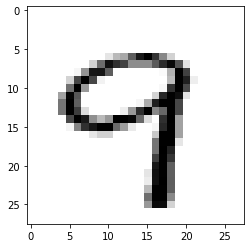

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

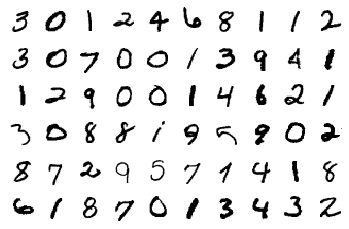

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
!pip install torchsummary
from torchsummary import summary

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(13)
            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(13)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 22

        self.convblock31 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock71 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock72 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(64)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.convblock3(x)# 22x22
        x = self.convblock31(x)# 22x22
        x = self.pool1(x) # 11x11

        
        x = self.convblock4(x) # 11x11
        x = self.convblock5(x) # 9x9
        x = self.convblock6(x) # 7x7
        x = self.convblock7(x) # 7x7
        x = self.convblock71(x) # 5x5
        x = self.convblock72(x) # 5x5
        x = self.gap(x)
        x = self.convblock8(x) #1x1
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [30]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 13, 26, 26]             117
              ReLU-2           [-1, 13, 26, 26]               0
           Dropout-3           [-1, 13, 26, 26]               0
       BatchNorm2d-4           [-1, 13, 26, 26]              26
            Conv2d-5           [-1, 13, 24, 24]           1,521
              ReLU-6           [-1, 13, 24, 24]               0
           Dropout-7           [-1, 13, 24, 24]               0
       BatchNorm2d-8           [-1, 13, 24, 24]              26
            Conv2d-9           [-1, 12, 22, 22]           1,404
             ReLU-10           [-1, 12, 22, 22]               0
          Dropout-11           [-1, 12, 22, 22]               0
      BatchNorm2d-12           [-1, 12, 22, 22]              24
           Conv2d-13           [-1, 12, 22, 22]             144
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [32]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12017760425806046 Batch_id=468 Accuracy=83.01: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2207, Accuracy: 9319/10000 (93.19%)

EPOCH: 1


Loss=0.08318773657083511 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0997, Accuracy: 9686/10000 (96.86%)

EPOCH: 2


Loss=0.05887983739376068 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0808, Accuracy: 9749/10000 (97.49%)

EPOCH: 3


Loss=0.11402835696935654 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9767/10000 (97.67%)

EPOCH: 4


Loss=0.12693895399570465 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9792/10000 (97.92%)

EPOCH: 5


Loss=0.06684994697570801 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9776/10000 (97.76%)

EPOCH: 6


Loss=0.10687761753797531 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9843/10000 (98.43%)

EPOCH: 7


Loss=0.14358006417751312 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9833/10000 (98.33%)

EPOCH: 8


Loss=0.05931262671947479 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:19<00:00, 23.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9844/10000 (98.44%)

EPOCH: 9


Loss=0.09501489996910095 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:19<00:00, 23.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9868/10000 (98.68%)

EPOCH: 10


Loss=0.0669662356376648 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.015688538551330566 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9859/10000 (98.59%)

EPOCH: 12


Loss=0.05854469910264015 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9852/10000 (98.52%)

EPOCH: 13


Loss=0.1154007688164711 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9865/10000 (98.65%)

EPOCH: 14


Loss=0.026717424392700195 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:19<00:00, 39.98it/s]



Test set: Average loss: 0.0430, Accuracy: 9867/10000 (98.67%)



Text(0.5, 1.0, 'Test Accuracy')

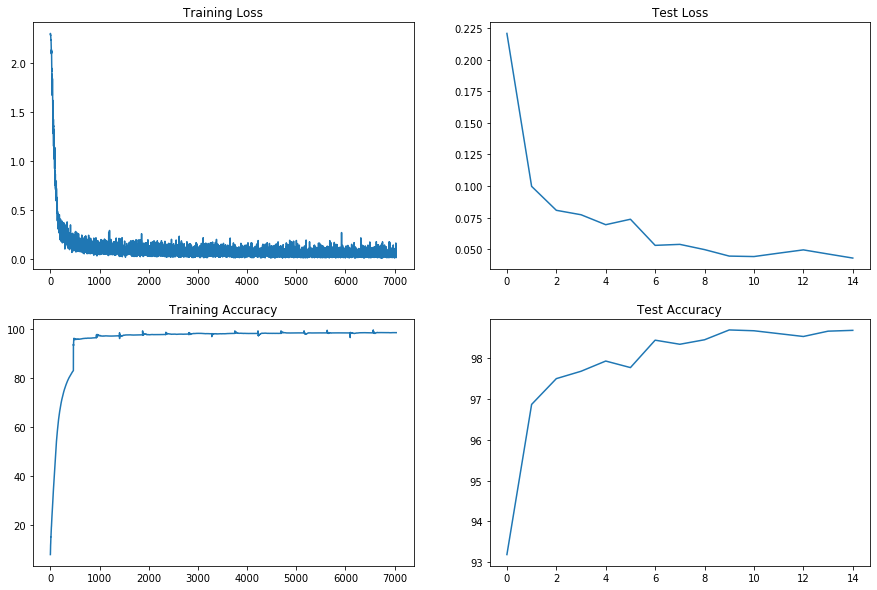

In [33]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")